In [1]:
import findspark
findspark.init()

import pyspark

from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Clustering").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/28 22:49:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
from pyspark.sql.functions import col, when
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import squarify

In [3]:
data = spark.read.csv("df_RFM.csv", inferSchema=True, header=True).drop("_c0")
data.printSchema()

root
 |-- Member_number: integer (nullable = true)
 |-- Recency: integer (nullable = true)
 |-- Frequency: integer (nullable = true)
 |-- Monetary: double (nullable = true)
 |-- R: integer (nullable = true)
 |-- F: integer (nullable = true)
 |-- M: integer (nullable = true)
 |-- RFM_Segment: integer (nullable = true)
 |-- RFM_Score: integer (nullable = true)



In [4]:
data.show(10)

+-------------+-------+---------+--------+---+---+---+-----------+---------+
|Member_number|Recency|Frequency|Monetary|  R|  F|  M|RFM_Segment|RFM_Score|
+-------------+-------+---------+--------+---+---+---+-----------+---------+
|         2193|     91|       27|  361.45|  3|  4|  4|        344|       11|
|         1793|     26|       25|   345.1|  4|  4|  4|        444|       12|
|         3289|      4|       29|  334.15|  4|  4|  4|        444|       12|
|         2433|      3|       30|  316.81|  4|  4|  4|        444|       12|
|         2743|    142|       17|  312.46|  2|  4|  4|        244|       10|
|         2811|    310|       20|  305.72|  1|  4|  4|        144|        9|
|         2990|    140|       24|  303.61|  3|  4|  4|        344|       11|
|         3872|     37|       30|  301.33|  4|  4|  4|        444|       12|
|         4753|     52|       23|   301.1|  4|  4|  4|        444|       12|
|         2993|    239|       15|  296.96|  2|  4|  4|        244|       10|

In [5]:
data.count()

3898

In [6]:
data.describe().show()

25/03/28 22:49:08 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------------------+------------------+-----------------+-----------------+-----------------+------------------+------------------+----------------+------------------+
|summary|     Member_number|           Recency|        Frequency|         Monetary|                R|                 F|                 M|     RFM_Segment|         RFM_Score|
+-------+------------------+------------------+-----------------+-----------------+-----------------+------------------+------------------+----------------+------------------+
|  count|              3898|              3898|             3898|             3898|             3898|              3898|              3898|            3898|              3898|
|   mean|3002.9599794766546| 187.7013853258081|9.882247306310928|84.89733196511037|              2.5|               2.5|               2.5|           277.5|               7.5|
| stddev| 1155.806001188376|159.91268820914237|5.269804259109583|55.34799494036805|1.118406891454291|1.1184068914542906|

In [7]:
data.columns

['Member_number',
 'Recency',
 'Frequency',
 'Monetary',
 'R',
 'F',
 'M',
 'RFM_Segment',
 'RFM_Score']

In [8]:
data.select('RFM_Score').distinct().orderBy('RFM_Score').show()

+---------+
|RFM_Score|
+---------+
|        3|
|        4|
|        5|
|        6|
|        7|
|        8|
|        9|
|       10|
|       11|
|       12|
+---------+



In [9]:
def rfm_level(df):
    # Check for special 'STARS' and 'NEW' conditions first
    if df.RFM_Score == 12:
        return 'STARS'
    elif df.R == 4 and df.F == 1 and df.M == 1:
        return 'NEW'
    # Then check for other conditions
    elif df.M == 4:
        return 'BIG SPENDER'
    elif df.F == 4:
        return 'LOYAL'
    elif df.R == 4:
        return 'ACTIVE'
    elif df.R == 1:
        return 'LOST'
    elif df.M == 1:
        return 'LIGHT'
    else:
        return 'REGULARS'


In [10]:
from pyspark.sql.functions import udf, struct
from pyspark.sql.types import StringType

# Create UDF
rfm_level_udf = udf(rfm_level, StringType())

# Apply the UDF to create new column
data = data.withColumn('RFM_Level', 
    rfm_level_udf(struct('RFM_Score', 'R', 'F', 'M')))

# Show results
data.show(5)

+-------------+-------+---------+--------+---+---+---+-----------+---------+-----------+
|Member_number|Recency|Frequency|Monetary|  R|  F|  M|RFM_Segment|RFM_Score|  RFM_Level|
+-------------+-------+---------+--------+---+---+---+-----------+---------+-----------+
|         2193|     91|       27|  361.45|  3|  4|  4|        344|       11|BIG SPENDER|
|         1793|     26|       25|   345.1|  4|  4|  4|        444|       12|      STARS|
|         3289|      4|       29|  334.15|  4|  4|  4|        444|       12|      STARS|
|         2433|      3|       30|  316.81|  4|  4|  4|        444|       12|      STARS|
|         2743|    142|       17|  312.46|  2|  4|  4|        244|       10|BIG SPENDER|
+-------------+-------+---------+--------+---+---+---+-----------+---------+-----------+
only showing top 5 rows



In [11]:
data.groupBy('RFM_Level').count().orderBy('count', ascending=False).show()

+-----------+-----+
|  RFM_Level|count|
+-----------+-----+
|       LOST|  881|
|   REGULARS|  870|
|BIG SPENDER|  687|
|     ACTIVE|  420|
|      LIGHT|  388|
|      LOYAL|  305|
|      STARS|  288|
|        NEW|   59|
+-----------+-----+



In [12]:
from pyspark.sql.functions import percentile_approx, count, round, sum, col, lit

# Calculate aggregations
rfm_agg = data.groupBy('RFM_Level').agg(
    percentile_approx('Recency', 0.5).alias('RecencyMean'),
    percentile_approx('Frequency', 0.5).alias('FrequencyMean'),
    percentile_approx('Monetary', 0.5).alias('MonetaryMean'),
    count('*').alias('Count')
)

# Calculate total count for percentage
total_count = data.count()

# Add Percent column
rfm_agg = rfm_agg.withColumn('Percent', 
    round(col('Count') * 100 / lit(total_count), 2))

rfm_agg = rfm_agg.orderBy('RFM_Level')
# Show results
rfm_agg.show()

+-----------+-----------+-------------+------------+-----+-------+
|  RFM_Level|RecencyMean|FrequencyMean|MonetaryMean|Count|Percent|
+-----------+-----------+-------------+------------+-----+-------+
|     ACTIVE|         28|            9|        70.4|  420|  10.77|
|BIG SPENDER|        128|           14|      144.39|  687|  17.62|
|      LIGHT|        157|            5|        28.9|  388|   9.95|
|       LOST|        397|            6|        41.0|  881|   22.6|
|      LOYAL|         85|           14|        92.7|  305|   7.82|
|        NEW|         16|            4|        21.6|   59|   1.51|
|   REGULARS|        145|            9|       70.96|  870|  22.32|
|      STARS|         30|           17|      163.66|  288|   7.39|
+-----------+-----------+-------------+------------+-----+-------+



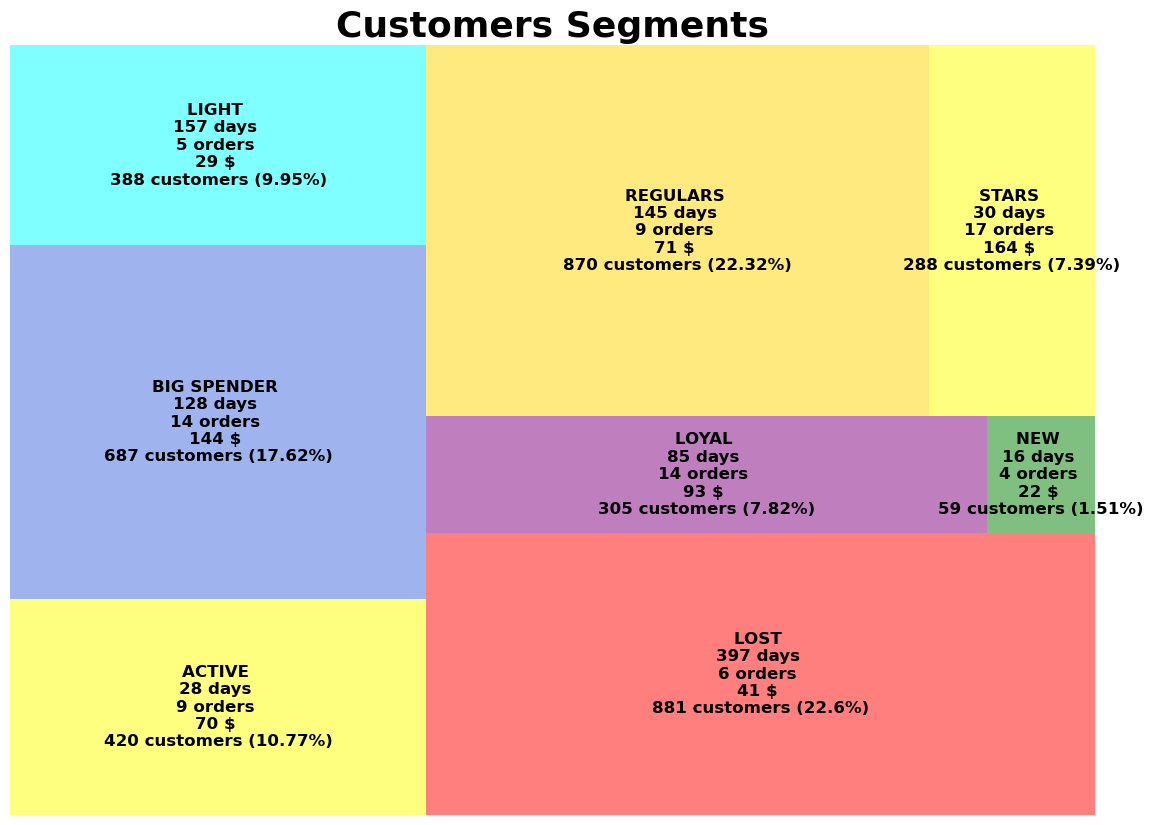

In [13]:
rfm_agg_pd = rfm_agg.toPandas()

# Create our plot and resize it
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(14, 10)

colors_dict = {'ACTIVE':'yellow','BIG SPENDER':'royalblue', 'LIGHT':'cyan',
               'LOST':'red', 'LOYAL':'purple', 'NEW':'green', 'STARS':'gold'}

squarify.plot(sizes=rfm_agg_pd['Count'],
              text_kwargs={'fontsize':12,'weight':'bold', 'fontname':"sans serif"},
              color=colors_dict.values(),
              label=['{} \n{:.0f} days \n{:.0f} orders \n{:.0f} $ \n{:.0f} customers ({}%)'.format(*rfm_agg_pd.iloc[i])
                      for i in range(0, len(rfm_agg_pd))], alpha=0.5 )

plt.title("Customers Segments",fontsize=26,fontweight="bold")
plt.axis('off')

plt.savefig('RFM Segments (Pyspark).png')
plt.show()

In [14]:
import plotly.express as px

fig = px.scatter(rfm_agg_pd, x="RecencyMean", y="MonetaryMean", size="FrequencyMean", color="RFM_Level",
           hover_name="RFM_Level", size_max = 60) 
fig.show()

## KMeans
### Kmeans clusters with the Elbow Method

In [15]:
# Select the required columns
data_kmeans = data.select('Recency', 'Frequency', 'Monetary')

# Show the first few rows
data_kmeans.show(5)

+-------+---------+--------+
|Recency|Frequency|Monetary|
+-------+---------+--------+
|     91|       27|  361.45|
|     26|       25|   345.1|
|      4|       29|  334.15|
|      3|       30|  316.81|
|    142|       17|  312.46|
+-------+---------+--------+
only showing top 5 rows



25/03/28 22:49:12 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/03/28 22:49:13 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
25/03/28 22:49:13 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


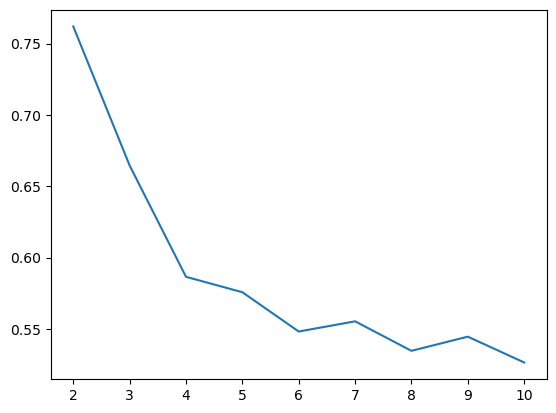

With k = 2- Silhouette = 0.7619558708181722
With k = 3- Silhouette = 0.6645514614502243
With k = 4- Silhouette = 0.5865495740267831
With k = 5- Silhouette = 0.5757584911180296
With k = 6- Silhouette = 0.5482165043760858
With k = 7- Silhouette = 0.555358179099408
With k = 8- Silhouette = 0.5346871943679183
With k = 9- Silhouette = 0.544607156891333
With k = 10- Silhouette = 0.5265235942804095



In [16]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.sql.functions import col, when
from pyspark.ml.evaluation import ClusteringEvaluator

# Convert features to vector column
assembler = VectorAssembler(inputCols=['Recency', 'Frequency', 'Monetary'], outputCol='features')
data_with_features = assembler.transform(data_kmeans)

scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(data_with_features)
scaled_data = scaler_model.transform(data_with_features)

# Calculate SSE for different k values
k_list = []
silhouette_list = []
sil_str =''

for k in range(2, 11):
    kmeans = KMeans(k=k, seed=42, featuresCol='features')
    model = kmeans.fit(scaled_data)
    k_list.append(k)

    #silhouette
    predictions = model.transform(scaled_data)

    #Evaluate clistering by computing Silhouette score
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions)
    silhouette_list.append(silhouette)
    
    sil_str = sil_str + 'With k = ' + str(k) + '- Silhouette = ' + str(silhouette) + '\n'

plt.plot(k_list, silhouette_list)
plt.show()
print(sil_str)

==> Chọn k = 5

#### Xây dựng mô hình với K = 5

In [17]:
kmeans = KMeans().setK(5).setSeed(1)  # Giả sử chọn 6 nhóm
model = kmeans.fit(scaled_data)

predictions = model.transform(scaled_data)

predictions.show(5)

+-------+---------+--------+-------------------+--------------------+----------+
|Recency|Frequency|Monetary|           features|     scaled_features|prediction|
+-------+---------+--------+-------------------+--------------------+----------+
|     91|       27|  361.45| [91.0,27.0,361.45]|[0.56906053559043...|         0|
|     26|       25|   345.1|  [26.0,25.0,345.1]|[0.16258872445440...|         0|
|      4|       29|  334.15|  [4.0,29.0,334.15]|[0.02501364991606...|         0|
|      3|       30|  316.81|  [3.0,30.0,316.81]|[0.01876023743704...|         0|
|    142|       17|  312.46|[142.0,17.0,312.46]|[0.88798457202023...|         0|
+-------+---------+--------+-------------------+--------------------+----------+
only showing top 5 rows



#### Đánh giá mô hình

==> Hiển thị dữ liệu theo cụm được dự đoán

In [18]:
selected_columns = ['Recency', 'Frequency', 'Monetary']

In [19]:
final_data = predictions.select('prediction', *selected_columns)

final_data.show(10)

+----------+-------+---------+--------+
|prediction|Recency|Frequency|Monetary|
+----------+-------+---------+--------+
|         0|     91|       27|  361.45|
|         0|     26|       25|   345.1|
|         0|      4|       29|  334.15|
|         0|      3|       30|  316.81|
|         0|    142|       17|  312.46|
|         4|    310|       20|  305.72|
|         0|    140|       24|  303.61|
|         0|     37|       30|  301.33|
|         0|     52|       23|   301.1|
|         0|    239|       15|  296.96|
+----------+-------+---------+--------+
only showing top 10 rows



In [20]:
predictions.groupBy('prediction').count().orderBy('prediction').show()

+----------+-----+
|prediction|count|
+----------+-----+
|         0|  597|
|         1| 1047|
|         2|  327|
|         3| 1192|
|         4|  735|
+----------+-----+



# Phân tích kết quả phân cụm


In [21]:
pandas_df = final_data.toPandas()

In [22]:
predictions.groupBy('prediction').count().orderBy('prediction').show()
cluster_summary = pandas_df.groupby("prediction").mean()
cluster_summary

+----------+-----+
|prediction|count|
+----------+-----+
|         0|  597|
|         1| 1047|
|         2|  327|
|         3| 1192|
|         4|  735|
+----------+-----+



,Recency,Frequency,Monetary
prediction,,,
0,63.768844,17.128978,175.854221
1,187.133715,9.492837,78.235425
2,551.455657,4.574924,37.846942
3,54.235738,9.600671,71.528389
4,343.790476,7.368707,63.121837



### Kết quả phân cụm có 5 cụm như sau:

| Cụm | Số lượng | Đặc trưng tiềm năng |
|-----|----------|----------------------|
| 0   | 597      | Phân khúc khách hàng trung thành, mua sắm thường xuyên và chi tiêu cao, có hành vi mua gần đây nhất. |
| 1   | 1047     | Phân khúc khách hàng tiềm năng, tần suất mua sắm ổn định nhưng chi tiêu trung bình, cần khuyến khích quay lại sớm hơn. |
| 2   | 327      | Phân khúc khách hàng không hoạt động, ít giao dịch và chi tiêu thấp, đã lâu không mua sắm. |
| 3   | 1192     | Phân khúc khách hàng phổ biến nhất, mua sắm gần đây với tần suất tốt nhưng chi tiêu trung bình. |
| 4   | 735      | Phân khúc khách hàng trung bình, tần suất và chi tiêu trung bình, đã khá lâu không quay lại. |

---

### Phân tích chi tiết từng cụm

#### Cụm 0: Recency = 63.77, Frequency = 14.87, Monetary = 175.85, Số lượng = 597
- **Recency (63.77 ngày)**: Mua gần đây (khoảng 2 tháng), rất tích cực.
- **Frequency (14.87)**: Tần suất cao nhất, mua sắm thường xuyên.
- **Monetary (175.85)**: Chi tiêu cao nhất, giá trị lớn.
- **Đặc trưng**: Đây là nhóm **khách hàng trung thành**, với 597 người, thường xuyên mua sắm và chi tiêu đáng kể. Là phân khúc quan trọng cần duy trì và chăm sóc đặc biệt.

#### Cụm 1: Recency = 187.13, Frequency = 8.63, Monetary = 78.24, Số lượng = 1047
- **Recency (187.13 ngày)**: Không mua trong khoảng 6 tháng, mức trung bình.
- **Frequency (8.63)**: Tần suất khá tốt, mua sắm đều đặn trong quá khứ.
- **Monetary (78.24)**: Chi tiêu trung bình, ổn định.
- **Đặc trưng**: Đây là nhóm **khách hàng tiềm năng**, với 1047 người, có hành vi mua sắm ổn định nhưng cần động lực để quay lại sớm hơn.

#### Cụm 2: Recency = 551.46, Frequency = 4.39, Monetary = 37.85, Số lượng = 327
- **Recency (551.46 ngày)**: Rất lâu không mua (gần 1.5-2 năm), không còn hoạt động.
- **Frequency (4.39)**: Tần suất thấp, hiếm khi mua sắm.
- **Monetary (37.85)**: Chi tiêu thấp, giá trị nhỏ.
- **Đặc trưng**: Đây là nhóm **khách hàng không hoạt động**, nhỏ nhất với 327 người. Họ có khả năng đã rời bỏ cửa hàng, cần chiến dịch kích hoạt lại hoặc bỏ qua.

#### Cụm 3: Recency = 54.24, Frequency = 8.70, Monetary = 71.53, Số lượng = 1192
- **Recency (54.24 ngày)**: Mua rất gần đây (khoảng 1.8 tháng), rất tích cực.
- **Frequency (8.70)**: Tần suất tốt, mua sắm đều đặn.
- **Monetary (71.53)**: Chi tiêu trung bình, không quá cao.
- **Đặc trưng**: Đây là nhóm **khách hàng phổ biến nhất**, với 1192 người, mua sắm gần đây và thường xuyên nhưng chi tiêu ở mức trung bình. Có thể khuyến khích tăng chi tiêu để nâng cấp lên nhóm trung thành.

#### Cụm 4: Recency = 343.79, Frequency = 6.86, Monetary = 63.12, Số lượng = 735
- **Recency (343.79 ngày)**: Lâu không mua (hơn 11 tháng), ít hoạt động.
- **Frequency (6.86)**: Tần suất trung bình, mua sắm không thường xuyên.
- **Monetary (63.12)**: Chi tiêu trung bình, không cao.
- **Đặc trưng**: Đây là nhóm **khách hàng trung bình**, với 735 người, từng hoạt động ổn nhưng đã ngừng mua gần đây. Có thể cần ưu đãi để kéo họ quay lại.

---

### Nhận xét tổng quan
- **Cụm 3 (1192 người)** là nhóm lớn nhất, đại diện cho khách hàng phổ biến, tích cực nhưng chi tiêu chưa cao.
- **Cụm 0 (597 người)** là nhóm trung thành, có giá trị cao nhất, cần ưu tiên chăm sóc.
- **Cụm 2 (327 người)** là nhóm nhỏ nhất, ít tiềm năng nhất, có thể không cần tập trung nhiều.
- **Cụm 1 (1047 người)** và **Cụm 4 (735 người)** chiếm số lượng lớn (tổng 1782 người), là các nhóm tiềm năng và trung bình, cần chiến lược phù hợp để kích thích.

---

### Ứng dụng thực tế
- **Cụm 0 (Trung thành)**: Tặng ưu đãi đặc biệt, chương trình khách hàng thân thiết hoặc VIP.
- **Cụm 1 (Tiềm năng)**: Đưa ra khuyến mãi vừa phải để khuyến khích quay lại sớm hơn và tăng chi tiêu.
- **Cụm 2 (Không hoạt động)**: Gửi email/tin nhắn nhắc nhở kèm khuyến mãi lớn, hoặc bỏ qua nếu không hiệu quả.
- **Cụm 3 (Phổ biến)**: Đề xuất sản phẩm giá trị cao hơn để tăng Monetary, biến họ thành khách hàng trung thành.
- **Cụm 4 (Trung bình)**: Cung cấp ưu đãi nhẹ để kéo họ quay lại, tập trung ít nguồn lực hơn so với Cụm 0 và 3.

---

### So sánh với 6 cụm trước đó
- Khi giảm từ 6 cụm xuống 5 cụm, dữ liệu được gộp lại, làm mất đi một nhóm trung gian (trước đây là Cụm 4 trong 6 cụm). Điều này khiến các cụm trở nên rõ ràng hơn về mặt phân khúc:
  - Cụm 0 và 3 vẫn đại diện cho nhóm tích cực (trung thành và phổ biến).
  - Cụm 2 vẫn là nhóm không hoạt động.
  - Cụm 1 và 4 hợp nhất các đặc điểm của nhóm trung bình và tiềm năng.

#### Trực quan hóa với biểu đồ 3 chiều

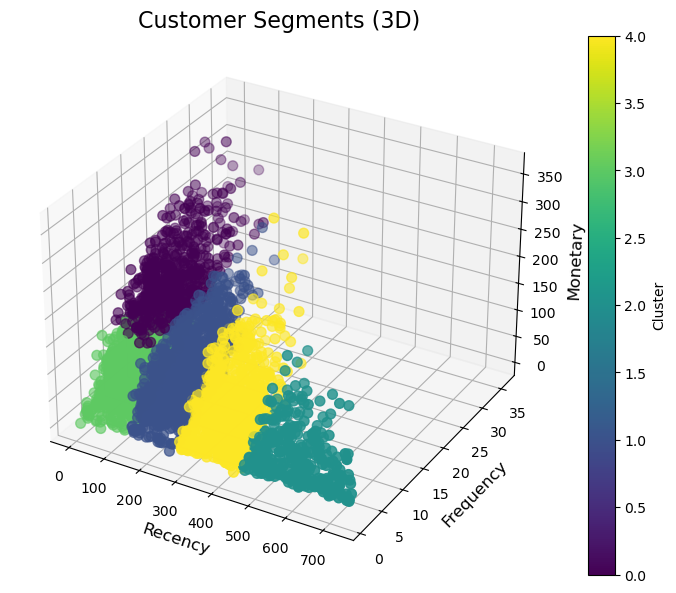

<Figure size 640x480 with 0 Axes>

In [23]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(pandas_df["Recency"], pandas_df["Frequency"], pandas_df["Monetary"], 
                     c=pandas_df["prediction"], cmap="viridis", s=50)

ax.set_title("Customer Segments (3D)", fontsize=16)
ax.set_xlabel("Recency", fontsize=12)
ax.set_ylabel("Frequency", fontsize=12)
ax.set_zlabel("Monetary", fontsize=12)

plt.colorbar(scatter, ax=ax, label="Cluster")
plt.show()
plt.savefig('Kmeans Unsupervised Segments (Pyspark).png')